In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import utm


## Load data

In [10]:
agg_data = r"C:\Users\johnk\Documents\projects\kyle\j0002\test_data\2200168_agg_preliminary.csv"
mag_data = r"C:\Users\johnk\Documents\projects\kyle\j0002\test_data\2200168_mag_ags_preliminary.csv"

data_obj = pd.read_csv(agg_data).to_xarray()

In [47]:
data_by_line = data_obj.groupby("Line")

# retrieve the line
line_ids = []
for group, group_ds in data_by_line:
    variable_keys = group_ds.keys()
    line_ids.append(group)


288


Number of lines in input: 288


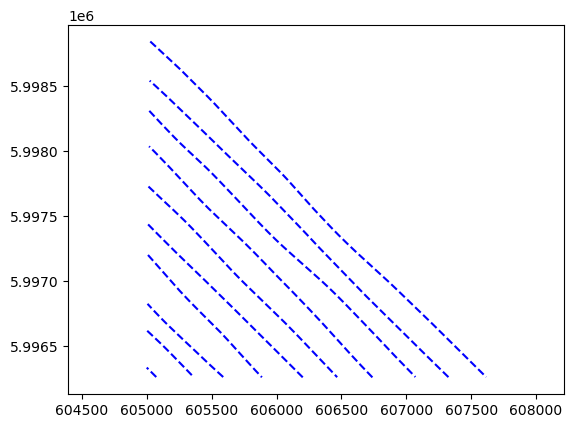

In [76]:
# store the amount of lines for historian purposes
number_of_lines = len(line_ids)
print(f"Number of lines in input: {number_of_lines}")

# get altitude for a line
ii = 0

diff_height = data_by_line[line_ids[ii]].Altitude - data_by_line[line_ids[ii]].Altitude_SRTM

# holder for possible bad data entry
problem_data = []

for ii in range(10):
    try:
        # get location information
        x, y, zone, letter = utm.from_latlon(data_by_line[line_ids[ii]].Latitude.to_numpy(), data_by_line[line_ids[ii]].Longitude.to_numpy())
        # plt.plot(diff_height, '.')
        # y = data_by_line[line_ids[ii]].Latitude.to_numpy()
        # x = data_by_line[line_ids[ii]].Longitude.to_numpy()
        plt.plot(x, y, '--b')
    except Exception as e:
        problem_data.append(ii)
        print(f" error with {e} \n\n {x}, \n\n {y} \n\n")
plt.axis('equal')
plt.show()

### Method for calculating line spacing analysis
- points are measured against each line looking for spacing more than allowed

C:\Users\johnk\AppData\Local\Temp\ipykernel_17900\4161619120.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_agg.set_yticklabels(ax_agg.get_yticks(), rotation=90)
C:\Users\johnk\AppData\Local\Temp\ipykernel_17900\4161619120.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_agg.set_yticklabels(ax_agg.get_yticks(), rotation=90)
C:\Users\johnk\AppData\Local\Temp\ipykernel_17900\4161619120.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_agg.set_yticklabels(ax_agg.get_yticks(), rotation=90)
C:\Users\johnk\AppData\Local\Temp\ipykernel_17900\4161619120.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_agg.set_yticklabels(ax_agg.get_yticks(), rotation=90)
C:\Users\johnk\AppData\Local\Temp\ipykernel_17900\4161619120.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_agg.set_yticklabels(ax_agg.get_yticks(), rot

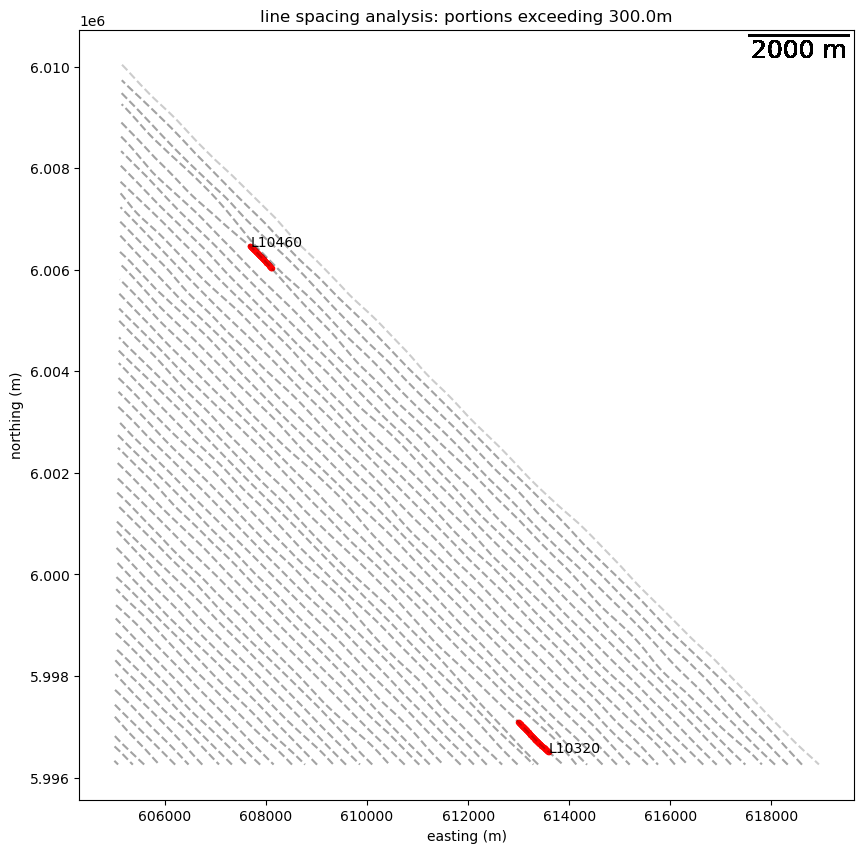

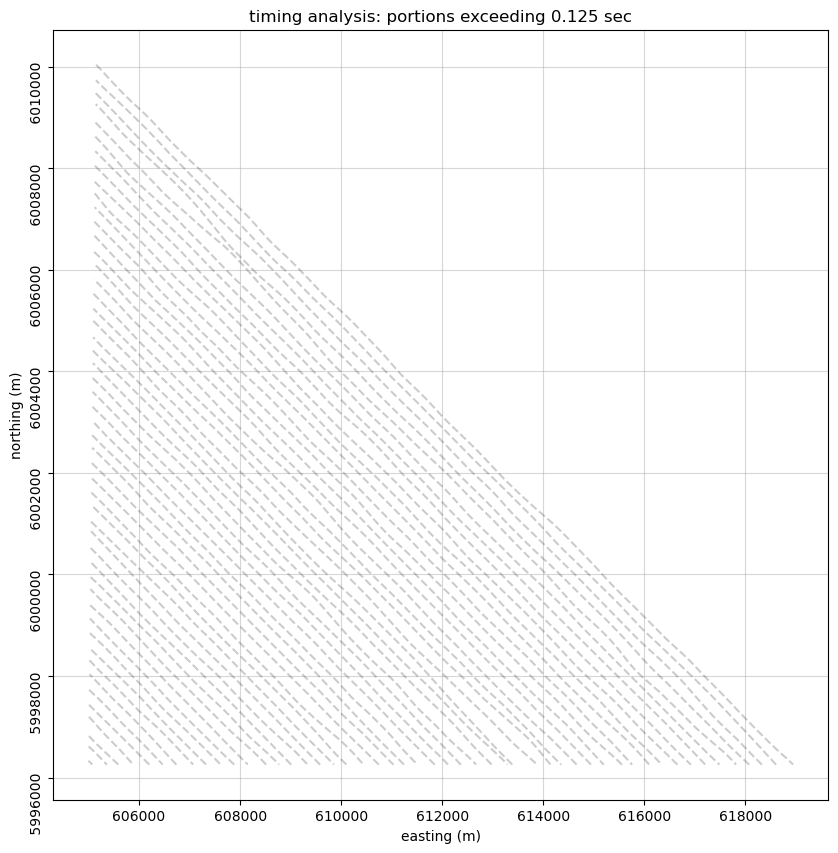

In [218]:
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=18)

time_limit = 5
half_time_constant = 0.5
line_seperation = 200
problem_dict = {}

# -----------------------------------------------------------------------------------------    
    
#                                           AGG

#

fig, ax = plt.subplots(1,1, figsize=(10, 10))
fig_, ax_agg = plt.subplots(1,1, figsize=(10, 10))

# from sklearn.neighbors import NearestNeighbors
for ii in range(50):

    x, y, zone, letter = utm.from_latlon(data_by_line[line_ids[ii]].Latitude.to_numpy(), data_by_line[line_ids[ii]].Longitude.to_numpy())
    samples = np.vstack([x, y]).T

    ax.plot(x, y, '--k', alpha=0.2)
    ax_agg.plot(x, y, '--k', alpha=0.2)

    if ii > 0:
        
        x2, y2, zone2, letter2 = utm.from_latlon(data_by_line[line_ids[ii-1]].Latitude.to_numpy(), data_by_line[line_ids[ii-1]].Longitude.to_numpy())
        
        samples2 = np.vstack([x2, y2]).T

        # in case of lines shorter than the other need use proper order to get distance
        xmax = np.max(x)
        xmin = np.min(x)
        ymax = np.max(y)
        ymin = np.min(y)

        dist = np.sqrt(np.sum(np.array([(xmax - xmin), (ymax - ymin)])**2))

        xmax2 = np.max(x2)
        xmin2 = np.min(x2)
        ymax2 = np.max(y2)
        ymin2 = np.min(y2)

        dist2 = np.sqrt(np.sum(np.array([(xmax2 - xmin2), (ymax2 - ymin2)])**2))
        # print(samples.shape, dist, dist2)
        ax.plot(x2, y2, '--k', alpha=0.2)

        if dist > dist2:
            # fit longer line and query the smallest
            neigh = NearestNeighbors(n_neighbors=1)
            neigh.fit(samples)
            idx_pick = neigh.kneighbors(samples2)

        else:
            # use opposite line assignment to determine line deviation
            # fit longer line and query the smallest
            neigh = NearestNeighbors(n_neighbors=1)
            neigh.fit(samples2)
            idx_pick = neigh.kneighbors(samples)

        # check to see if any points are over 1.5x distance
        if (idx_pick[0] > (line_seperation* 1.5)).sum() > 0:
            
            # find where they are
            find_excess_distance = np.where(idx_pick[0] > (line_seperation* 1.5))

            # grab the offending points
            # if dist > dist2:
            excess_points = samples[idx_pick[1][find_excess_distance]]
            # else:
            #     excess_points = samples2[idx_pick[1][find_excess_distance]]

            # add the points to the plot
            ax.plot(excess_points[:, 0], excess_points[:, 1], '.r')
            ax.annotate(line_ids[ii], xy=(excess_points[0, 0], excess_points[0, 1]))

    # -----------------------------------------------------------------------------------------    
    
    # check the timing agg

    #

    difference_between_samples = np.diff(data_by_line[line_ids[ii]].UTC_Time1980)

    if (difference_between_samples >= half_time_constant).sum() > 0:

        # find where they are
        find_excess_time = np.where(difference_between_samples >= half_time_constant)

        # grab the offending points
        time_excess_points = samples[find_excess_time]

        # add points to time plot
        ax_agg.plot(time_excess_points[:, 0], time_excess_points[:, 1], '.r')
        ax_agg.annotate(line_ids[ii], xy=(time_excess_points[0, 0], time_excess_points[0, 1]))

    # pretty up the plot
    ax_agg.grid(True, alpha=0.5)
    ax_agg.set_yticklabels(ax_agg.get_yticks(), rotation=90)
    ax_agg.yaxis.set_major_formatter(FormatStrFormatter('% i'))
    scalebar = AnchoredSizeBar(ax_agg.transData,
                            2000, '2000 m', 'upper right', 
                            pad=0.1,
                            color='black',
                            frameon=False,
                            size_vertical=10,
                            fontproperties=fontprops)

    ax.add_artist(scalebar)
    ax.set_xlabel('easting (m)')
    ax.set_ylabel('northing (m)')
    ax.set_title(f'line spacing analysis: portions exceeding {line_seperation * 1.5}m')
    # ax_agg.add_artist(scalebar)
    ax_agg.set_xlabel('easting (m)')
    ax_agg.set_ylabel('northing (m)')
    ax_agg.set_title(f'timing analysis: portions exceeding {time_limit} sec')


## lets look at time

In [216]:
0.125 * 40

5.0

## mag data

KeyError: 'L10010'

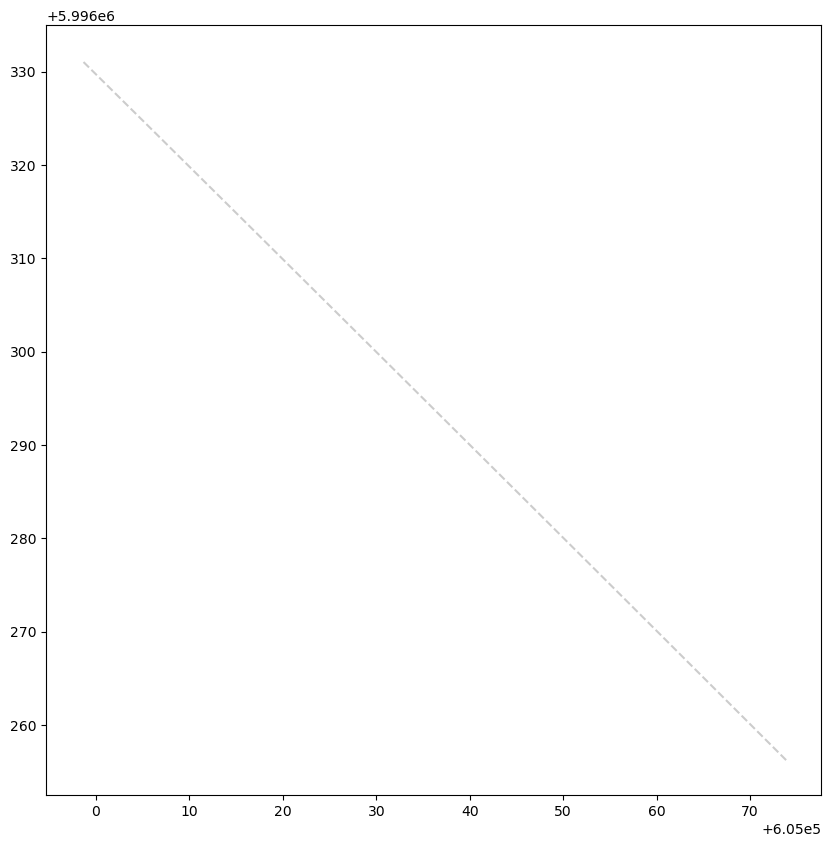

In [225]:
# mag_data_obj = pd.read_csv(mag_data).to_xarray()

# mag_data_by_line = mag_data_obj.groupby("Line")

# # retrieve the line
# mag_line_ids = []
# for group, group_ds in mag_data_by_line:
#     variable_keys = group_ds.keys()
#     mag_line_ids.append(group)

# -----------------------------------------------------------------------------------------    
    
#                                           MAG

#

fig, ax = plt.subplots(1,1, figsize=(10, 10))
# fig_, ax_mag = plt.subplots(1,1, figsize=(10, 10))

# from sklearn.neighbors import NearestNeighbors
for ii in range(1):

    x, y, zone, letter = utm.from_latlon(mag_data_by_line[mag_line_ids[ii]].Latitude.to_numpy(), mag_data_by_line[mag_line_ids[ii]].Longitude.to_numpy())
    samples = np.vstack([x, y]).T

    ax.plot(x, y, '--k', alpha=0.2)
    ax_agg.plot(x, y, '--k', alpha=0.2)

    # check diurnal

    print(mag_data_obj[mag_line_ids[ii]])

# -----------------------------------------------------------------------------------------    
    
    # check the timing mag

    

    # difference_between_samples = np.diff(data_by_line[line_ids[ii]].UTC_Time1980)

    # if (difference_between_samples >= time_limit).sum() > 0:

    #     # find where they are
    #     find_excess_time = np.where(difference_between_samples >= time_limit)

    #     # grab the offending points
    #     time_excess_points = samples[find_excess_time]

    #     # add points to time plot
    #     ax_agg.plot(time_excess_points[:, 0], time_excess_points[:, 1], '.r')
    #     ax_agg.annotate(line_ids[ii], xy=(time_excess_points[0, 0], time_excess_points[0, 1]))

In [220]:
mag_data_obj

<xarray.Dataset>
Dimensions:                (index: 1773593)
Coordinates:
  * index                  (index) int64 0 1 2 3 ... 1773590 1773591 1773592
Data variables: (12/543)
    Line                   (index) object 'L10010' 'L10010' ... 'T19150'
    Altitude               (index) float64 340.1 340.3 340.4 ... 454.3 454.4
    CompMag                (index) float64 5.437e+04 5.437e+04 ... 5.452e+04
    cosmic                 (index) float64 nan nan nan nan ... nan nan nan nan
    Date                   (index) float64 2.024e+03 2.024e+03 ... 2.024e+03
    Diurnal                (index) float64 5.403e+04 5.403e+04 ... 5.403e+04
    ...                     ...
    temp_ext               (index) float64 nan nan nan nan ... nan nan nan nan
    th_raw                 (index) float64 nan nan nan nan ... nan nan nan nan
    time_ssm               (index) float64 nan nan nan nan ... nan nan nan nan
    u_raw                  (index) float64 nan nan nan nan ... nan nan nan nan
    u_up_raw               (index) float64 nan nan nan nan ... nan nan nan nan
    UTC_Time1980           (index) float64 1.376e+09 1.376e+09 ... 1.375e+09

In [167]:
# load h5
import h5py

hdf5_pc = h5py.File(r"C:\Users\johnk\Documents\git\Caravel\data\caraveldev_file_store\2022\C00001_cj\P00001_testp\P00001_S00003_L2_ProcessingAndQC\processed_time_series\AAA-ABR-r84_ensemble stacking_11.hdf5", 'r')

In [169]:
hdf5_pc.keys()

<KeysViewHDF5 ['current_stack', 'decay', 'processed_time_series\\AAA-ABR-r84_ensemble stacking_11.hdf5', 'voltage_stack', 'vs_window_centers', 'vs_window_widths']>